In [1]:
import pandas as pd
import requests
import datetime

## Data Ingestion

In [2]:
class BinanceIngestionData:
    def __init__(self, symbol, interval, start_date, end_date):
        self.symbol = symbol
        self.interval = interval
        self.start_date = start_date
        self.end_date = end_date
        self.base_url = "https://api.binance.com/api/v3/klines"

    def fetch_data(self):
        params = {
            "symbol": self.symbol,
            "interval": self.interval,
            "startTime": int(datetime.datetime.strptime(self.start_date, "%Y-%m-%d").timestamp() * 1000),
            "endTime": int(datetime.datetime.strptime(self.end_date, "%Y-%m-%d").timestamp() * 1000),
            "limit": 1000
        }
        response = requests.get(self.base_url, params=params)
        data = response.json()

        if response.status_code != 200 or not data:
            raise Exception("Failed to fetch data. Check your symbol, interval, or date range.")

        return data

    def process_data(self, data):
        df = pd.DataFrame(data, columns=[
            "Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", 
            "Quote Asset Volume", "Number of Trades", "Taker Buy Base Asset Volume", 
            "Taker Buy Quote Asset Volume", "Ignore"
        ])

        # Convert to proper data types
        df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
        df.set_index("Open Time", inplace=True)
        df = df.astype({
            "Open": "float", 
            "High": "float", 
            "Low": "float", 
            "Close": "float", 
            "Volume": "float", 
            "Quote Asset Volume": "float", 
            "Number of Trades": "int", 
            "Taker Buy Base Asset Volume": "float", 
            "Taker Buy Quote Asset Volume": "float"
        })

        return df

    def save_to_csv(self, df, file_path):
        df.to_csv(file_path)
        print(f"Data saved to {file_path}")

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1d"
    end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.now() - datetime.timedelta(days=730)).strftime("%Y-%m-%d")

    binance_data = BinanceIngestionData(symbol, interval, start_date, end_date)

    raw_data = binance_data.fetch_data()
    processed_data = binance_data.process_data(raw_data)
    binance_data.save_to_csv(processed_data, "BTC_2Y_Binance.csv")


Data saved to BTC_2Y_Binance.csv


In [3]:
df = pd.read_csv("/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/BTC_2Y_Binance.csv")
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,0
1,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,0
2,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,0
3,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,0
4,2023-01-19,20677.47,21192.00,20659.19,21071.59,251385.84925,1674172799999,5.243024e+09,5819932,124924.23436,2.605630e+09,0


## Feature Engineering

In [4]:
class FeatureEngineering:
    def __init__(self, df):
        self.df = df

    def add_features(self):
        
        self.df = self.df.rename(columns={"Open Time": "ds", "Close": "y"})
        self.df = self.df.drop(columns=["Ignore"], errors='ignore')
        self.df['High_Low_Diff'] = self.df['High'] - self.df['Low']
        self.df['Open_Close_Diff'] = self.df['Open'] - self.df['y']
        self.df['Average_Price'] = (self.df['High'] + self.df['Low'] + self.df['y']) / 3
        self.df['Volume_Weighted_Price'] = self.df['Quote Asset Volume'] / self.df['Volume']
        

        return self.df

In [5]:
feature_engineering = FeatureEngineering(df)
engineered_data = feature_engineering.add_features()
engineered_data.head()

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,High_Low_Diff,Open_Close_Diff,Average_Price,Volume_Weighted_Price
0,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,499.73,81.26,20824.416667,20782.347682
1,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,862.57,-312.66,21090.393333,21047.817694
2,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,806.14,50.84,21207.856667,21207.049892
3,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,1242.85,454.82,20911.540000,21086.866328
4,2023-01-19,20677.47,21192.00,20659.19,21071.59,251385.84925,1674172799999,5.243024e+09,5819932,124924.23436,2.605630e+09,532.81,-394.12,20974.260000,20856.481563


In [7]:
from prophet import Prophet

def Prophet_Features(df):
    df.reset_index(inplace=True)
    pd.to_datetime(df["ds"])
    prophet_model = Prophet(
                        growth='linear',
                        seasonality_mode='additive',
                        interval_width=0.95,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False
                    )
    prophet_model.fit(df)
    prophet_results = prophet_model.predict(df.drop('y', axis=1))
        
    return prophet_results

In [8]:
prophet_data = Prophet_Features(engineered_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [9]:
prophet_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-15,21084.316521,14015.596850,30118.383651,21084.316521,21084.316521,1321.706885,1321.706885,1321.706885,1394.465738,1394.465738,1394.465738,-72.758853,-72.758853,-72.758853,0.0,0.0,0.0,22406.023406
1,2023-01-16,21135.187340,14357.744590,30519.628819,21135.187340,21135.187340,1506.231217,1506.231217,1506.231217,1394.465738,1394.465738,1394.465738,111.765479,111.765479,111.765479,0.0,0.0,0.0,22641.418557
2,2023-01-17,21186.058158,14519.553702,30767.937724,21186.058158,21186.058158,1379.955281,1379.955281,1379.955281,1394.465738,1394.465738,1394.465738,-14.510456,-14.510456,-14.510456,0.0,0.0,0.0,22566.013440
3,2023-01-18,21236.928977,14588.839385,31493.840716,21236.928977,21236.928977,1535.373938,1535.373938,1535.373938,1394.465738,1394.465738,1394.465738,140.908200,140.908200,140.908200,0.0,0.0,0.0,22772.302915
4,2023-01-19,21287.799796,14366.251119,30164.962839,21287.799796,21287.799796,1318.677820,1318.677820,1318.677820,1394.465738,1394.465738,1394.465738,-75.787917,-75.787917,-75.787917,0.0,0.0,0.0,22606.477616


In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def Triple_ETS(df):
    # Add ETS multiplicative and additive models
    df['Triple_Multiplicative_ETS'] = ExponentialSmoothing(
        df['y'], trend='mul', seasonal='mul', seasonal_periods=24*7
    ).fit().fittedvalues

    df['Triple_Additive_ETS'] = ExponentialSmoothing(
        df['y'], trend='add', seasonal='add', seasonal_periods=24*7
    ).fit().fittedvalues

    # Avoid dropping columns prematurely
    if 'index' in df.columns:
        df.drop(columns=['index'], inplace=True)

    return df


In [11]:
data = Triple_ETS(engineered_data)

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [66]:
data.head()

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,High_Low_Diff,Open_Close_Diff,Average_Price,Volume_Weighted_Price,Triple_Multiplicative_ETS,Triple_Additive_ETS
0,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,499.73,81.26,20824.416667,20782.347682,27471.787178,28003.277646
1,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,862.57,-312.66,21090.393333,21047.817694,21591.195883,21844.241480
2,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,806.14,50.84,21207.856667,21207.049892,21235.592507,21495.871984
3,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,1242.85,454.82,20911.540000,21086.866328,21366.516376,21695.846099
4,2023-01-19,20677.47,21192.00,20659.19,21071.59,251385.84925,1674172799999,5.243024e+09,5819932,124924.23436,2.605630e+09,532.81,-394.12,20974.260000,20856.481563,20574.624949,20432.968931


In [67]:
prophet_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-15,21084.316521,14015.596850,30118.383651,21084.316521,21084.316521,1321.706885,1321.706885,1321.706885,1394.465738,1394.465738,1394.465738,-72.758853,-72.758853,-72.758853,0.0,0.0,0.0,22406.023406
1,2023-01-16,21135.187340,14357.744590,30519.628819,21135.187340,21135.187340,1506.231217,1506.231217,1506.231217,1394.465738,1394.465738,1394.465738,111.765479,111.765479,111.765479,0.0,0.0,0.0,22641.418557
2,2023-01-17,21186.058158,14519.553702,30767.937724,21186.058158,21186.058158,1379.955281,1379.955281,1379.955281,1394.465738,1394.465738,1394.465738,-14.510456,-14.510456,-14.510456,0.0,0.0,0.0,22566.013440
3,2023-01-18,21236.928977,14588.839385,31493.840716,21236.928977,21236.928977,1535.373938,1535.373938,1535.373938,1394.465738,1394.465738,1394.465738,140.908200,140.908200,140.908200,0.0,0.0,0.0,22772.302915
4,2023-01-19,21287.799796,14366.251119,30164.962839,21287.799796,21287.799796,1318.677820,1318.677820,1318.677820,1394.465738,1394.465738,1394.465738,-75.787917,-75.787917,-75.787917,0.0,0.0,0.0,22606.477616


In [68]:
def Merging_DFs(df1, df2):
    df1['ds'] = df1['ds'].astype(str)
    df2['ds'] = df2['ds'].astype(str)
    featured_df = pd.merge(df1, df2, how='left', on='ds')
    return featured_df

In [69]:
final_df = Merging_DFs(data, prophet_data)
final_df

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,...,1394.465738,1394.465738,1394.465738,-72.758853,-72.758853,-72.758853,0.0,0.0,0.0,22406.023406
1,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,...,1394.465738,1394.465738,1394.465738,111.765479,111.765479,111.765479,0.0,0.0,0.0,22641.418557
2,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,...,1394.465738,1394.465738,1394.465738,-14.510456,-14.510456,-14.510456,0.0,0.0,0.0,22566.013440
3,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,...,1394.465738,1394.465738,1394.465738,140.908200,140.908200,140.908200,0.0,0.0,0.0,22772.302915
4,2023-01-19,20677.47,21192.00,20659.19,21071.59,251385.84925,1674172799999,5.243024e+09,5819932,124924.23436,...,1394.465738,1394.465738,1394.465738,-75.787917,-75.787917,-75.787917,0.0,0.0,0.0,22606.477616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-01-09,95060.61,95382.32,91203.67,92552.49,34544.83685,1736467199999,3.217670e+09,6027161,15323.62663,...,1394.465738,1394.465738,1394.465738,-75.787917,-75.787917,-75.787917,0.0,0.0,0.0,100546.274834
726,2025-01-10,92552.49,95836.00,92206.02,94726.11,31482.86424,1736553599999,2.962085e+09,5531444,15617.43823,...,1394.465738,1394.465738,1394.465738,9.995662,9.995662,9.995662,0.0,0.0,0.0,100944.581928
727,2025-01-11,94726.10,95050.94,93831.73,94599.99,7047.90430,1736639999999,6.656860e+08,1496191,3412.37671,...,1394.465738,1394.465738,1394.465738,-99.612114,-99.612114,-99.612114,0.0,0.0,0.0,101147.497669
728,2025-01-12,94599.99,95450.10,93711.19,94545.06,8606.86622,1736726399999,8.132788e+08,1658863,4028.33031,...,1394.465738,1394.465738,1394.465738,-72.758853,-72.758853,-72.758853,0.0,0.0,0.0,101486.874445


In [91]:
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class XGBoostForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the XGBoostForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for XGBoost model.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Add time-based features (e.g., day, month, weekday)
        self.data['day'] = self.data['ds'].dt.day
        self.data['month'] = self.data['ds'].dt.month
        self.data['weekday'] = self.data['ds'].dt.weekday

    def prepare_features(self, training_period=730):
        """
        Prepare features for the model.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        
        features = training_data[['day', 'month', 'weekday']]
        target = training_data['y']
        
        return features, target, training_data

    def train_model(self, training_period=730):
        """
        Train the XGBoost model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        features, target, _ = self.prepare_features(training_period)
        
        X_train = features
        y_train = target

        self.model = xgb.XGBRegressor(objective='reg:squarederror', 
                                      n_estimators=1000,
                                        learning_rate=0.01,  # Lower learning rate for small changes
                                        max_depth=6,  # Adjust tree depth
                                        subsample=0.8,  # Use a fraction of samples
                                        colsample_bytree=0.8  # Use a fraction of features
                                      )
        self.model.fit(X_train, y_train)

    def forecast(self, future_periods=180):
        """
        Forecast the future data using XGBoost.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        last_date = self.data['ds'].max()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]
        
        future_features = pd.DataFrame({
            'day': [d.day for d in forecast_dates],
            'month': [d.month for d in forecast_dates],
            'weekday': [d.weekday() for d in forecast_dates]
        })
        
        forecast_values = self.model.predict(future_features)
        
        mean = self.data['y'].mean()

        adjustment_factor = (mean/2) * 2.5  # Statistical Techniques
        
        forecast_values += adjustment_factor
        
        forecast = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast_values
        })
        
        return forecast



    def evaluate_model(self, training_period=730):
        """
        Evaluate the model using MAE, MSE, RMSE, and MAPE.

        Parameters:
        - training_period: Number of days to use for training.

        Returns:
        - dict: Dictionary containing evaluation metrics.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_test = features
        y_test = target

        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    def plot_forecast(self, forecast):
        """
        Plot forecast using Plotly.

        Parameters:
        - forecast: DataFrame containing the forecasted data.
        """
        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data['y'], mode='lines', name='Actual', line=dict(color='blue')))

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))

        # Layout and styling
        fig.update_layout(
            title='XGBoost Forecast for the Next 6 Months',
            xaxis_title='Date',
            yaxis_title='Price',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    # Assuming engineered_data is your input data
    xgboost_forecasting = XGBoostForecasting(data=final_df, date_column='ds', target_column='y')
    xgboost_forecasting.preprocess_data()
    xgboost_forecasting.train_model(training_period=730)
    forecast = xgboost_forecasting.forecast(future_periods=180)  # 6 months forecast
    evaluation_metrics = xgboost_forecasting.evaluate_model(training_period=730)

    # Plot the forecast
    xgboost_forecasting.plot_forecast(forecast)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(f"MAE: {evaluation_metrics['MAE']}")
    print(f"MSE: {evaluation_metrics['MSE']}")
    print(f"RMSE: {evaluation_metrics['RMSE']}")
    print(f"MAPE: {evaluation_metrics['MAPE']}")


Evaluation Metrics:
MAE: 18362.228961900688
MSE: 366393767.12016624
RMSE: 19141.414971735143
MAPE: 0.44353279591317046


In [29]:
from prophet import Prophet
from datetime import timedelta
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

class ProphetForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the ProphetForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column
        self.model = Prophet(daily_seasonality=True, yearly_seasonality=True, 
                             weekly_seasonality=True, seasonality_mode='multiplicative')

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for Prophet.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])

    def train_model(self, training_period=730):
        """
        Train the Prophet model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        self.model.fit(training_data)

    def forecast(self, future_periods=180):
        """
        Forecast the future data.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        future_dates = self.model.make_future_dataframe(periods=future_periods, freq='D')
        forecast = self.model.predict(future_dates)
        return forecast

    def calculate_ema(self, period, column='y'):
        """
        Calculate Exponential Moving Average (EMA).

        Parameters:
        - period: The EMA period.
        - column: The column to calculate EMA on.

        Returns:
        - DataFrame with an additional EMA column.
        """
        self.data[f'EMA_{period}'] = self.data[column].ewm(span=period, adjust=False).mean()

    def identify_ema_signals(self, short_period=12, long_period=26):
        """
        Identify EMA crossover signals.

        Parameters:
        - short_period: Short EMA period.
        - long_period: Long EMA period.

        Returns:
        - DataFrame of signals with types and corresponding data.
        """
        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        signals = []

        for i in range(1, len(self.data)):
            signal = {'time': self.data['ds'].iloc[i], 'type': None}

            # Bullish Crossover
            if (
                self.data[f'EMA_{short_period}'].iloc[i - 1] < self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] >= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bullish Crossover'
                signals.append(signal)

            # Bearish Crossover
            elif (
                self.data[f'EMA_{short_period}'].iloc[i - 1] > self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] <= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bearish Crossover'
                signals.append(signal)

        return pd.DataFrame(signals)

    def plot_forecast_with_indicators(self, forecast, short_period=12, long_period=26):
        """
        Plot forecast along with EMA indicators and signals using Plotly for interactivity.

        Parameters:
        - forecast: Forecast DataFrame.
        - short_period: Short EMA period.
        - long_period: Long EMA period.
        """
        fig = go.Figure()

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='blue')))

        # Calculate and plot EMAs
        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{short_period}'], mode='lines', name=f'EMA {short_period}', line=dict(color='green', dash='dash')))
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{long_period}'], mode='lines', name=f'EMA {long_period}', line=dict(color='red', dash='dash')))

        # Identify and plot signals
        signals = self.identify_ema_signals(short_period, long_period)
        for _, signal in signals.iterrows():
            color = 'lime' if signal['type'] == 'Bullish Crossover' else 'orange'
            fig.add_trace(go.Scatter(x=[signal['time']], y=[self.data.loc[self.data['ds'] == signal['time'], 'y'].values[0]],
                                     mode='markers', marker=dict(color=color, size=10), name=signal['type']))

        # Layout and styling
        fig.update_layout(
            title='Forecast with EMA Indicators',
            xaxis_title='Date',
            yaxis_title='Value',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    prophet_forecasting = ProphetForecasting(data=final_df, date_column='ds', target_column='y')
    prophet_forecasting.preprocess_data()
    prophet_forecasting.train_model(training_period=730)
    forecast = prophet_forecasting.forecast(future_periods=180)
    prophet_forecasting.plot_forecast_with_indicators(forecast, short_period=12, long_period=26)



INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [39]:
final_df.columns

Index(['ds', 'Open', 'High', 'Low', 'y', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'High_Low_Diff', 'Open_Close_Diff',
       'Average_Price', 'Volume_Weighted_Price', 'Triple_Multiplicative_ETS',
       'Triple_Additive_ETS', 'trend', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

Epoch 1/50


/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0401
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
Epoch 16/50
18/

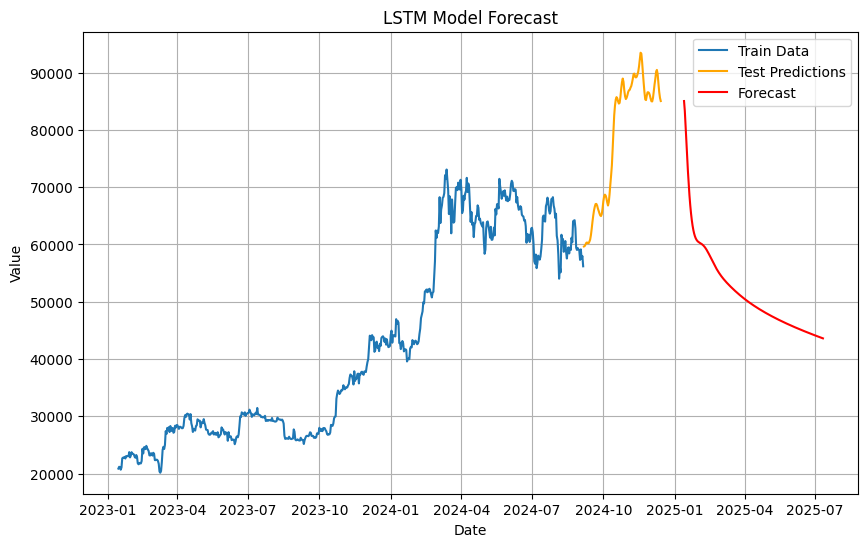

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

class LSTMForecasting:
    def __init__(self, data: pd.DataFrame):
        """
        Initializes the LSTMForecasting class with the given data.

        Parameters:
        - data: pandas DataFrame containing the time series data with a 'y' column.
        """
        self.data = data
        self.train_data = None
        self.test_data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    
    def prepare_data(self, training_period: int = 730, look_back: int = 30):
        """
        Prepares the training and testing datasets for LSTM.

        Parameters:
        - training_period: Number of days to use for training. Default is 730 days.
        - look_back: Number of past days to use for prediction. Default is 30.
        """
        if 'ds' in self.data.columns:
            self.data.rename(columns={'ds': 'timestamp'}, inplace=True)

        if 'timestamp' not in self.data.columns:
            raise KeyError("'timestamp' column is missing. Ensure the 'ds' column is renamed or included.")

        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')

        if self.data['timestamp'].isnull().any():
            raise ValueError("Invalid datetime values in 'timestamp' column.")

        self.data.set_index('timestamp', inplace=True)

        if len(self.data) < (training_period + look_back):
            raise ValueError(
                f"Insufficient data for the specified training period ({training_period}) "
                f"and look-back window ({look_back}). Total rows: {len(self.data)}"
            )

        normalized_data = self.scaler.fit_transform(self.data[['y']])

        train_data = normalized_data[:training_period]
        test_data = normalized_data[training_period:]
        self.train_data = train_data
        self.test_data = test_data

        def create_dataset(dataset, look_back):
            X, y = [], []
            for i in range(len(dataset) - look_back):
                X.append(dataset[i:(i + look_back), 0])
                y.append(dataset[i + look_back, 0])
            return np.array(X), np.array(y)

        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        return X_train, y_train, X_test, y_test


    def build_model(self, input_shape):
        """
        Builds the LSTM model.

        Parameters:
        - input_shape: Shape of the input data for the LSTM model.
        """
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(LSTM(32))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def train_model(self, X_train, y_train, epochs=50, batch_size=32):
        """
        Trains the LSTM model.

        Parameters:
        - X_train: Training input data.
        - y_train: Training output data.
        - epochs: Number of epochs for training. Default is 50.
        - batch_size: Batch size for training. Default is 32.
        """
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the LSTM model on the test data.

        Parameters:
        - X_test: Test input data.
        - y_test: Test output data.

        Returns:
        - evaluation_metrics: Dictionary containing evaluation metrics (MSE, RMSE).
        """
        predictions = self.model.predict(X_test)
        predictions = self.scaler.inverse_transform(predictions)
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        evaluation_metrics = {'MSE': mse, 'RMSE': rmse}
        return evaluation_metrics, predictions

    def forecast(self, last_sequence, future_periods=180):
        """
        Forecast future values using the trained LSTM model.

        Parameters:
        - last_sequence: The last input sequence from the test data.
        - future_periods: Number of future periods to forecast.

        Returns:
        - forecast: Array of forecasted values.
        """
        forecast = []
        current_sequence = last_sequence.copy()

        for _ in range(future_periods):
            # Predict the next value
            next_value = self.model.predict(current_sequence)
            
            # Reshape next_value to match (1, 1, 1)
            next_value = next_value.reshape(1, 1, 1)
            
            # Update the current_sequence by appending the next_value
            current_sequence = np.append(current_sequence[:, 1:, :], next_value, axis=1)
            
            # Append the predicted value to the forecast
            forecast.append(next_value[0, 0, 0])

        # Reverse normalization
        forecast = self.scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
        return forecast


    def plot_forecast(self, predictions, forecast, look_back):
        """
        Plots the forecasted values along with the historical data.

        Parameters:
        - predictions: Predicted values for the test set.
        - forecast: Forecasted values for future periods.
        - look_back: Look-back period used for LSTM.
        """
        plt.figure(figsize=(10, 6))
        train_range = range(look_back, look_back + len(self.train_data))
        test_range = range(len(self.train_data) + look_back, len(self.train_data) + look_back + len(predictions))

        plt.plot(self.data.index[:len(self.train_data)], self.scaler.inverse_transform(self.train_data), label='Train Data')
        plt.plot(self.data.index[len(self.train_data):len(self.train_data) + len(predictions)], predictions, label='Test Predictions', color='orange')
        plt.plot(pd.date_range(self.data.index[-1], periods=len(forecast), freq='D'), forecast, label='Forecast', color='red')

        plt.title('LSTM Model Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example Usage:
if __name__ == "__main__":
    # Load your dataset (must include 'timestamp' and 'y' columns)
    # df = pd.read_csv('/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/BTC_2Y_Binance.csv')

    # Initialize the LSTMForecasting class
    lstm_forecasting = LSTMForecasting(final_df)

    # Prepare the data
    X_train, y_train, X_test, y_test = lstm_forecasting.prepare_data(training_period=600, look_back=30)

    # Build the LSTM model
    lstm_forecasting.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    lstm_forecasting.train_model(X_train, y_train, epochs=50, batch_size=32)

    # Evaluate the model
    evaluation_metrics, predictions = lstm_forecasting.evaluate_model(X_test, y_test)
    print(f"Model Evaluation: {evaluation_metrics}")

    # Forecast future values
    last_sequence = X_test[-1:]
    forecast = lstm_forecasting.forecast(last_sequence, future_periods=180)

    # Plot the results
    lstm_forecasting.plot_forecast(predictions, forecast, look_back=30)
# 

In [72]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class LGBMForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the LGBMForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for LGBM model.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Add time-based features (e.g., day, month, weekday)
        self.data['day'] = self.data['ds'].dt.day
        self.data['month'] = self.data['ds'].dt.month
        self.data['weekday'] = self.data['ds'].dt.weekday

    def prepare_features(self, training_period=730):
        """
        Prepare features for the model.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        
        # Features (excluding 'ds' and 'y')
        features = training_data[['day', 'month', 'weekday']]
        target = training_data['y']
        
        return features, target, training_data

    def train_model(self, training_period=730):
        """
        Train the LGBM model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_train = features
        y_train = target

        # LGBM Model
        self.model = lgb.LGBMRegressor(
            objective='regression',
            n_estimators=1000,
            learning_rate=0.01,  # Lower learning rate for small changes
            max_depth=6,  # Adjust tree depth
            subsample=0.8,  # Use a fraction of samples
            colsample_bytree=0.8  # Use a fraction of features
        )
        self.model.fit(X_train, y_train)

    def forecast(self, future_periods=180):
        """
        Forecast the future data using LGBM.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        last_date = self.data['ds'].max()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]
        
        # Create future features (using the same pattern as the data preprocessing)
        future_features = pd.DataFrame({
            'day': [d.day for d in forecast_dates],
            'month': [d.month for d in forecast_dates],
            'weekday': [d.weekday() for d in forecast_dates]
        })
        
        # Forecast the future data
        forecast_values = self.model.predict(future_features)
        
        # Add 60,000 to the forecast values
        forecast_values += 61000
        
        # Create the forecast DataFrame
        forecast = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast_values
        })
        
        return forecast

    def evaluate_model(self, training_period=730):
        """
        Evaluate the model using MAE, MSE, RMSE, and MAPE.

        Parameters:
        - training_period: Number of days to use for training.

        Returns:
        - dict: Dictionary containing evaluation metrics.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_test = features
        y_test = target

        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    def plot_forecast(self, forecast):
        """
        Plot forecast using Plotly.

        Parameters:
        - forecast: DataFrame containing the forecasted data.
        """
        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data['y'], mode='lines', name='Actual', line=dict(color='blue')))

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))

        # Layout and styling
        fig.update_layout(
            title='LGBM Forecast for the Next 6 Months',
            xaxis_title='Date',
            yaxis_title='Price',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    # Assuming engineered_data is your input data
    lgbm_forecasting = LGBMForecasting(data=final_df, date_column='ds', target_column='y')
    lgbm_forecasting.preprocess_data()
    lgbm_forecasting.train_model(training_period=730)
    forecast = lgbm_forecasting.forecast(future_periods=180)  # 6 months forecast
    evaluation_metrics = lgbm_forecasting.evaluate_model(training_period=730)

    # Plot the forecast
    lgbm_forecasting.plot_forecast(forecast)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(f"MAE: {evaluation_metrics['MAE']}")
    print(f"MSE: {evaluation_metrics['MSE']}")
    print(f"RMSE: {evaluation_metrics['RMSE']}")
    print(f"MAPE: {evaluation_metrics['MAPE']}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 730, number of used features: 3
[LightGBM] [Info] Start training from score 48873.093977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Evaluation Metrics:
MAE: 18926.65109222766
MSE: 386206695.7366209
RMSE: 19652.142268379317
MAPE: 0.4569792418738889
